In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt

from data.dataLoader import ClientPreprocessTrain, ClientPreprocessTest, GlobalPreprocess
from data.distribution import data_label_distribution
from globle.trainer.trainer import GlobalTrainer
from globle.trainer.evaluator import GlobalEvaluator
from client.trainer.trainer import ClientTrainer
from client.trainer.evaluator import ClientEvaluator
from models.models import model
from configs.confLoader import *

digits	count
1:	5
2:	2
3:	2
5:	1
6:	3
7:	2
9:	1
torch.Size([16, 1, 28, 28])


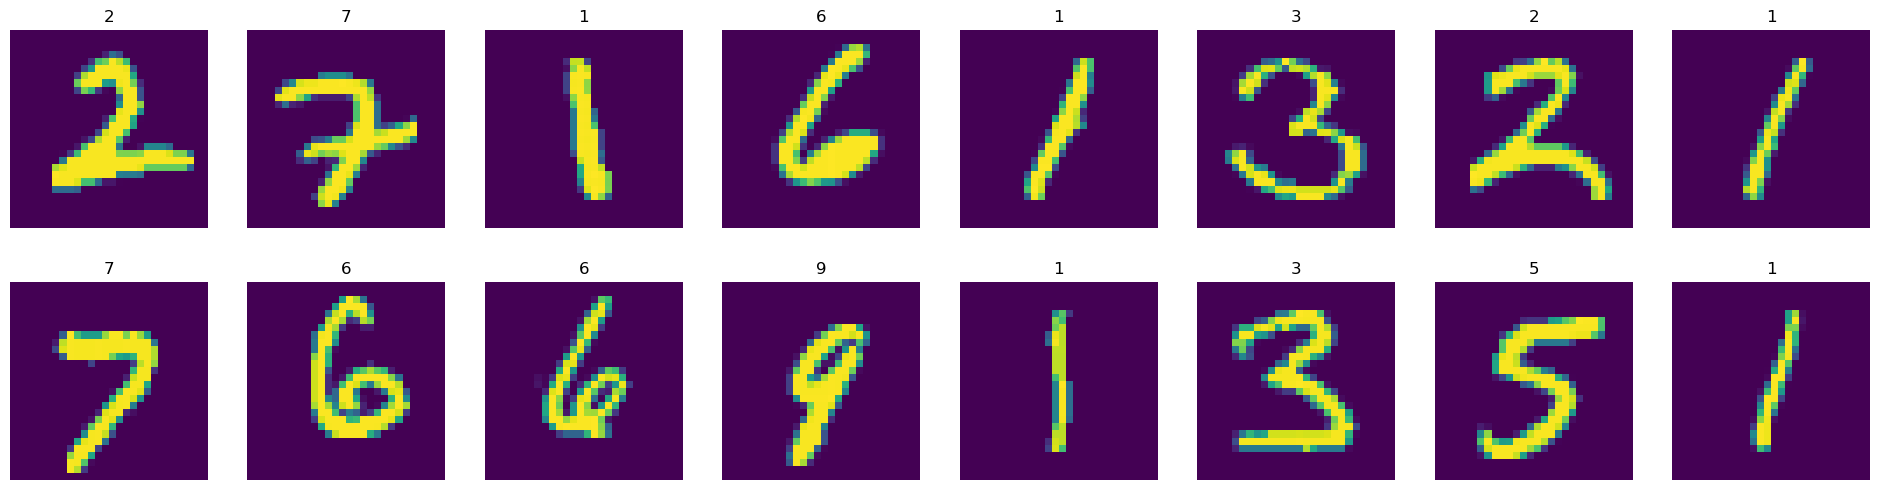

In [2]:
client_test = ClientPreprocessTest()
data, target = next(iter(client_test[0]))
label_count = (torch.unique(target, return_counts=True))
print('digits\tcount')
for label, count in zip(label_count[0], label_count[1]):
    print(int(label), ':\t', int(count), sep='')
print(data.shape)
# data = transforms.ToPILImage(data.squeeze())
fig = plt.figure(figsize=(24, 6))
for i in range(len(target)):
    fig.add_subplot(2, 8, (i+1))
    plt.imshow(data[i].squeeze())
    plt.axis('off')
    plt.title(int(target[i]))


In [3]:
global_model = model
print(global_model)

ClassicCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [4]:
global_trainer = GlobalTrainer(global_model)

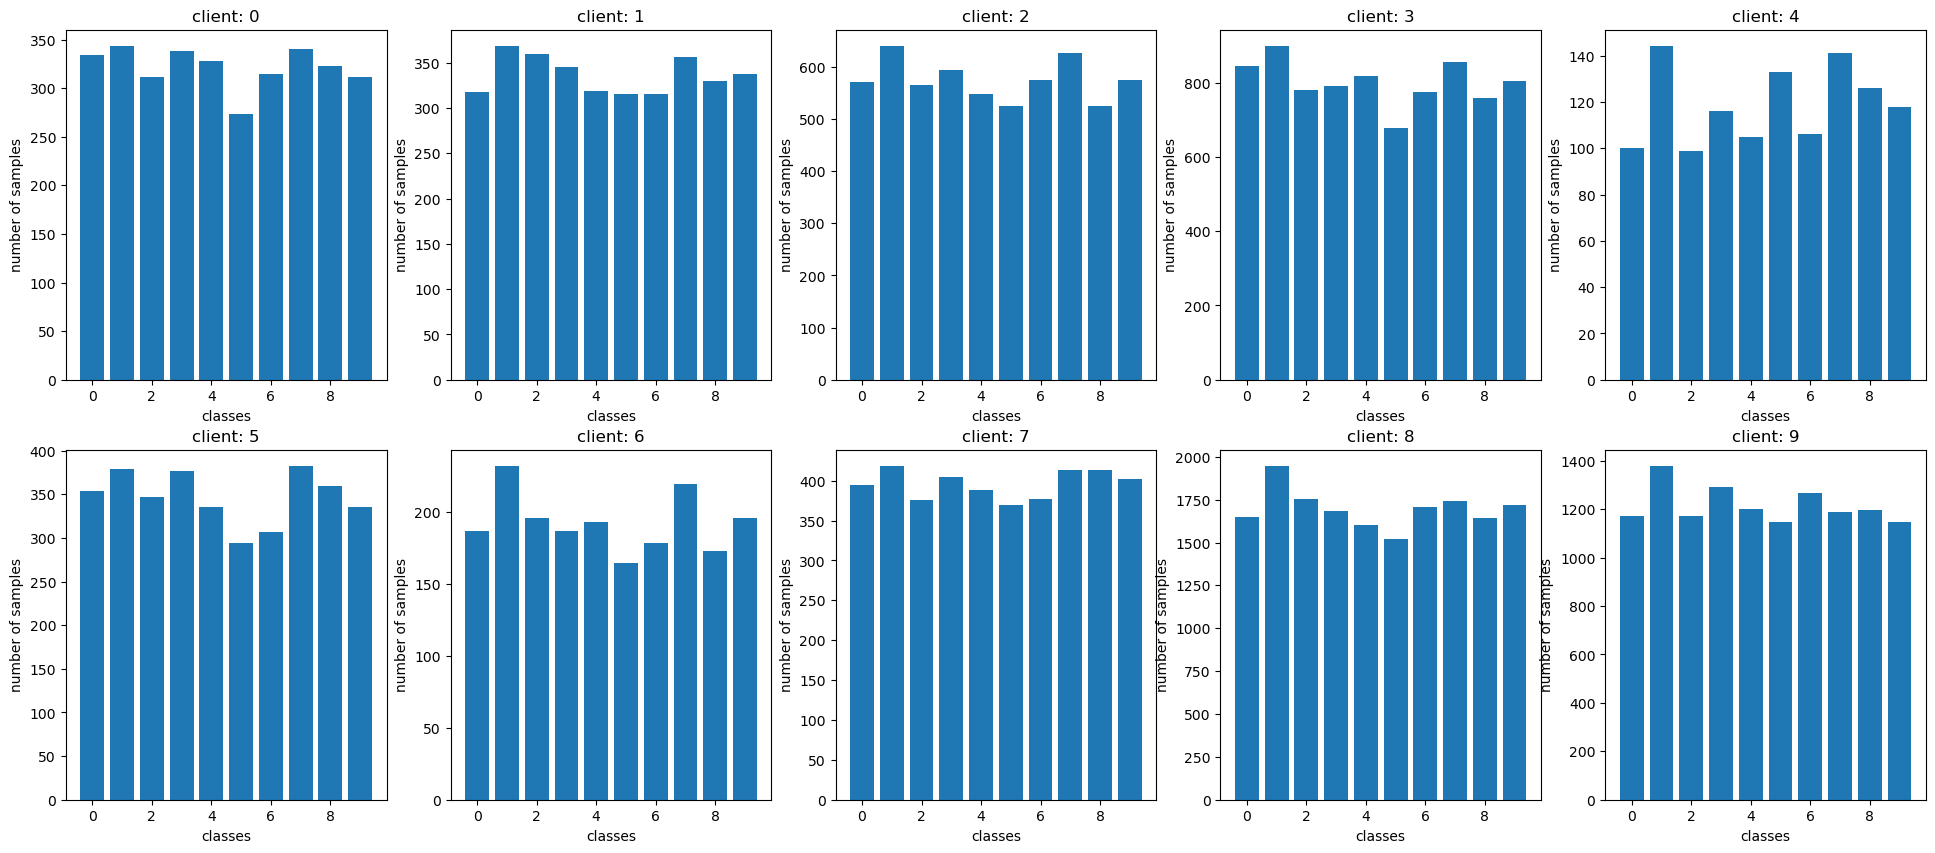

In [5]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    distribution = data_label_distribution(global_trainer.trainset[i])
    plt.bar(distribution.keys(), distribution.values())
    plt.title(f'client: {i}')
    plt.xlabel('classes')
    plt.ylabel('number of samples')


In [6]:
global_trainer.train()

global_training_epoch: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


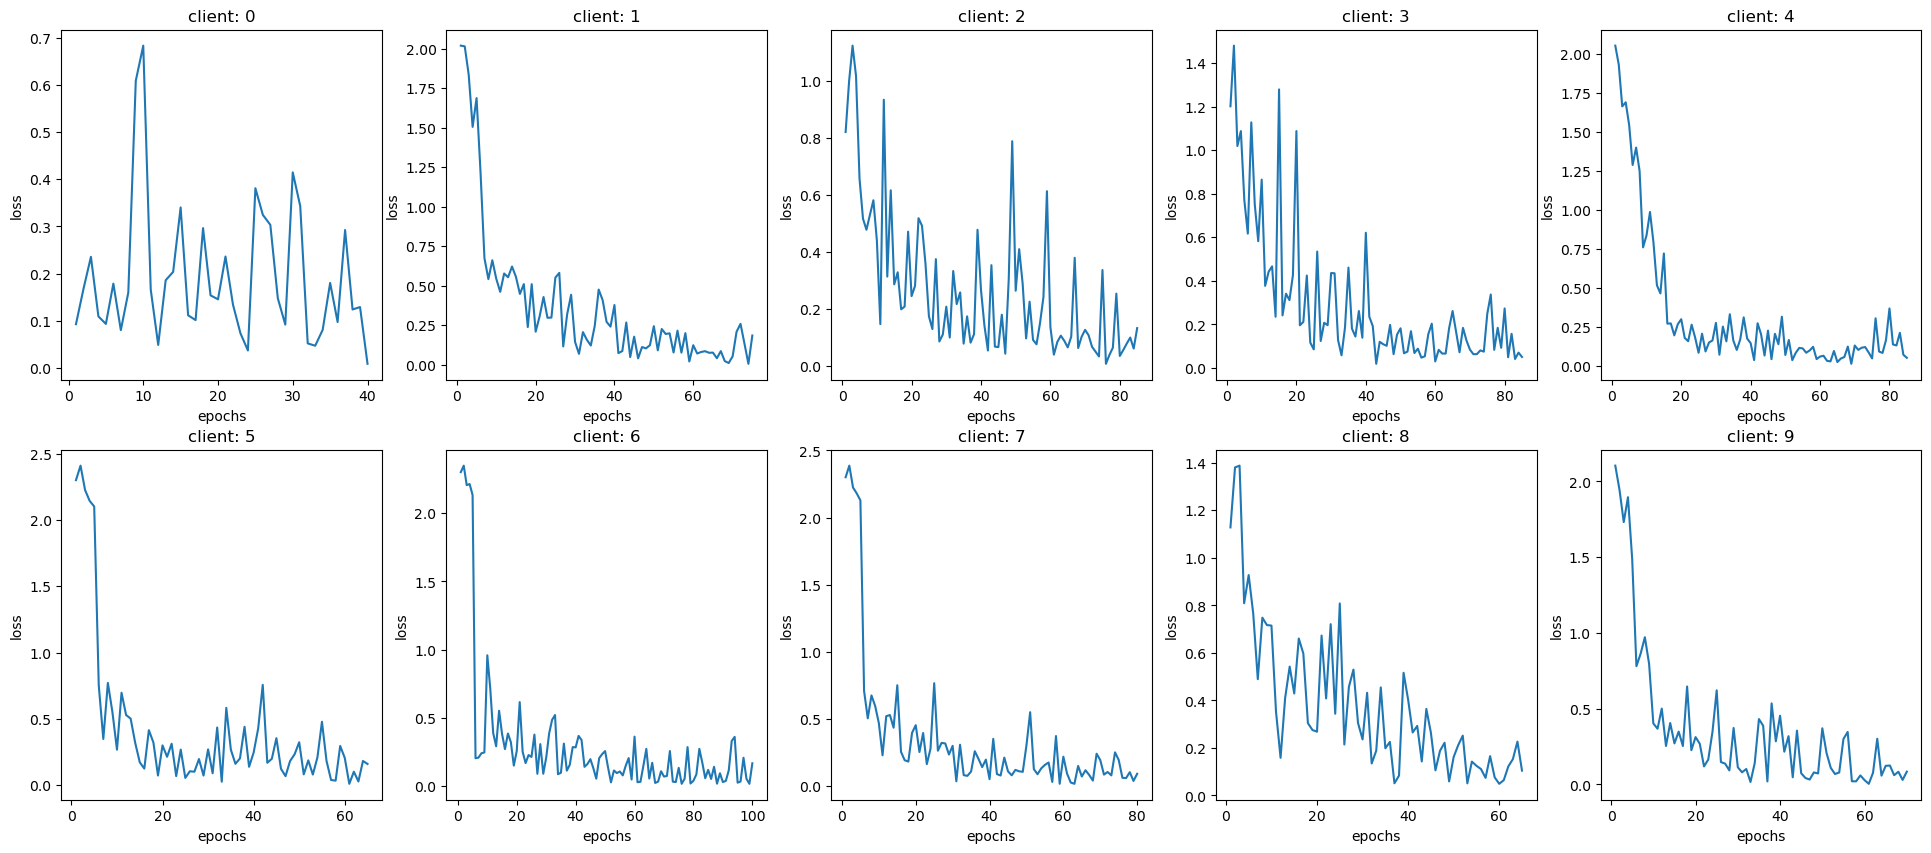

In [7]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    X = global_trainer.client_trainer_set[i].loss_history
    Y = [i+1 for i in range(len(X))]
    plt.plot(Y, X)
    plt.title(f'client: {i}')
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [8]:
global_test = GlobalPreprocess()

client_evaluator_set = [ClientEvaluator(i, global_model, client_test[i]) for i in range(n_clients)]
global_evaluator = GlobalEvaluator(global_model, global_test)

In [9]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(n_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= n_clients
avg_client_loss /= n_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, n_clients)
    

client [0]: 100%|██████████| 37/37 [00:00<00:00, 165.17it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 61/61 [00:00<00:00, 196.24it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 53/53 [00:00<00:00, 203.26it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 67/67 [00:00<00:00, 204.90it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 45/45 [00:00<00:00, 204.37it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 86/86 [00:00<00:00, 209.83it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 64/64 [00:00<00:00, 221.68it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 89/89 [00:00<00:00, 199.83it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 97/97 [00:00<00:00, 220.20it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 32/32 [00:00<00:00, 209.11it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>


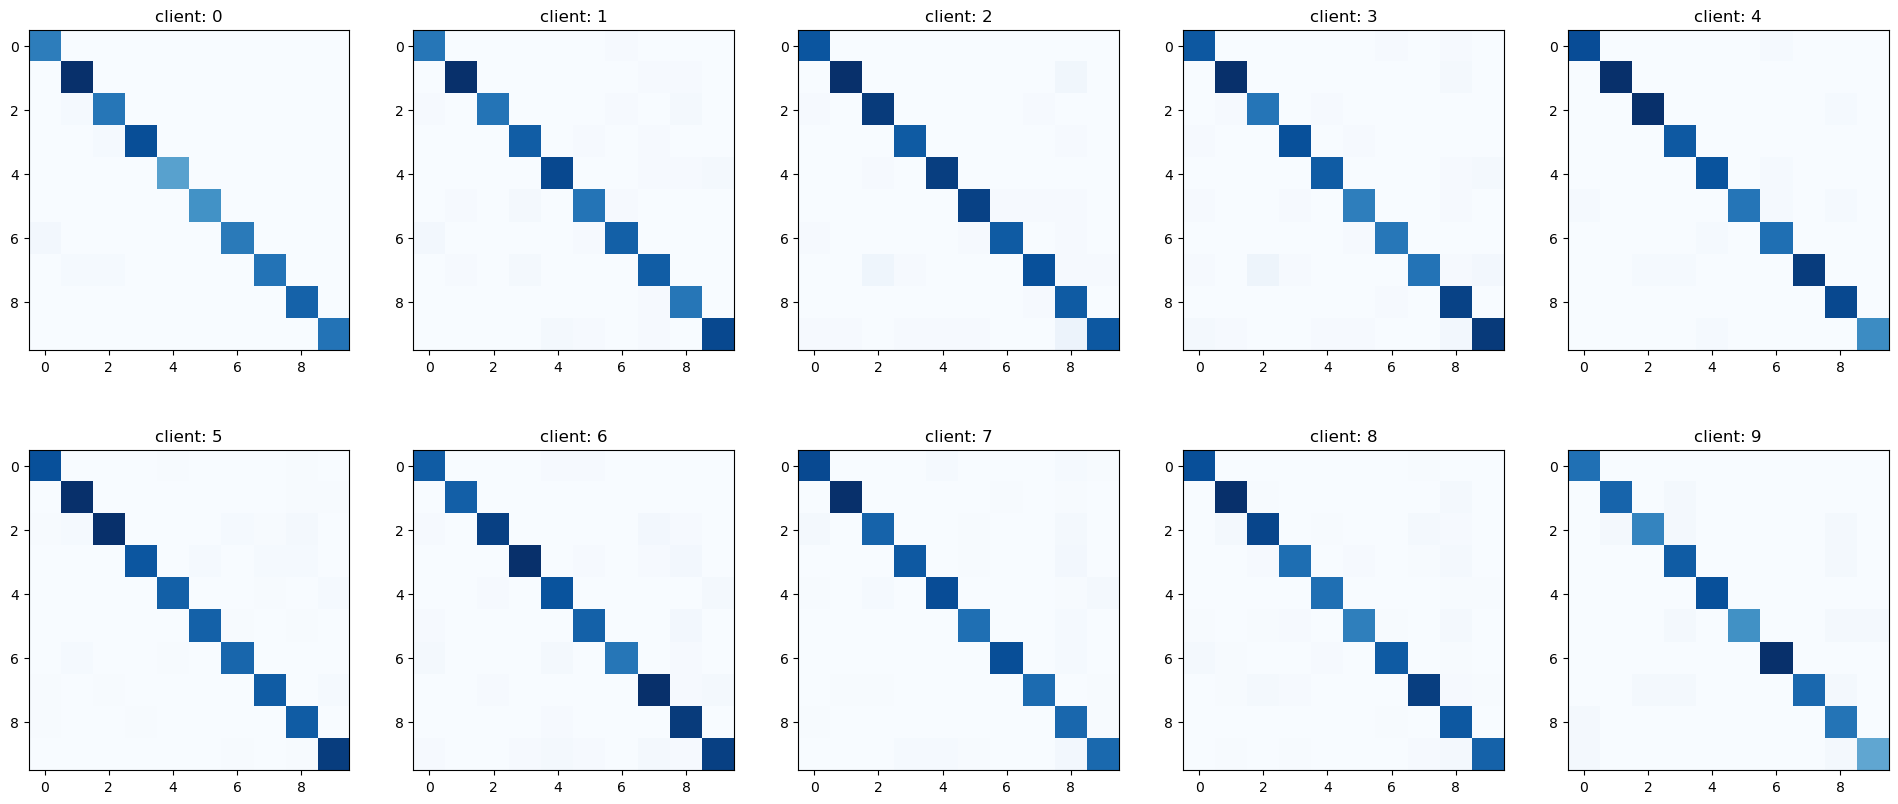

In [10]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
    plt.title(f'client: {i}')


<BarContainer object of 10 artists>

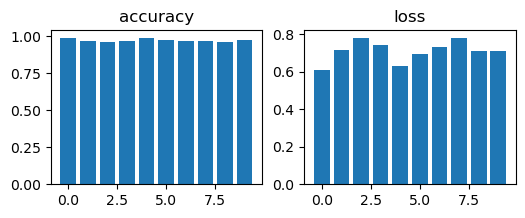

In [11]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].accuracy for i in range(n_clients)])
plt.title('accuracy')
fig.add_subplot(1, 2, 2)
plt.title('loss')   
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].loss for i in range(n_clients)])


In [12]:
global_evaluator.test()

global_evaluation: 100%|██████████| 157/157 [00:01<00:00, 89.82it/s]


Text(0.5, 1.0, 'clieint average')

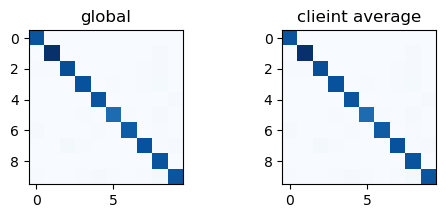

In [13]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('clieint average')


In [14]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.9702428343949044 	Client avg Accuracy 0.9717373007866529
Global Loss 0.7184312372940698 	Client avg Loss 0.710488627040429
